In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import itertools
import random
import matplotlib
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm, tqdm_notebook

import sys
sys.path.append('/home/ajhnam/sudoku/src/sudoku')

from board import Board
from solutions import Solutions
import utils

In [2]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

torch.set_default_tensor_type('torch.DoubleTensor')

In [3]:
def vector_encode(board_string):
    dim_x, dim_y, board = board_string.split('.')
    max_digit = int(dim_x) * int(dim_y)
    vector = np.zeros((max_digit*len(board),), dtype=np.float64)
    for i in range(len(board)):
        if board[i] != '0':
            vector[i*max_digit + int(board[i]) - 1] = 1
        else:
            vector[i*max_digit:(i+1)*max_digit] = 1/max_digit
    return vector

def get_board_entries(board_string):
    return np.array(list(board_string[4:]), dtype=np.int)

In [4]:
def shuffle_numbers(seed_board_string, number_orders):
    """
    Given a seed_board string and a string with the new order for top row of board, generates derivative board
    e.g.
    >>> shuffle_numbers('2.2.0204030120400400', ['2143'])
    ['2.2.0103040210300300']
    """
    max_digit = int(seed_board_string[0]) * int(seed_board_string[2])
    digits = seed_board_string[4:]
    assert np.all([int(digits[i]) == i+1 or int(digits[i]) == 0 for i in range(max_digit)]) # check if seed
    if type(number_orders) == str:
        number_orders = [number_orders]
        
    all_digits = {str(i) for i in range(1, max_digit+1)}
    shuffled_board_strings = []
    for number_order in number_orders:
        assert len(number_order) == max_digit
        mapping = {str(i+1): str(number_order[i]) for i in range(max_digit)}
        assert set(mapping.values()) == all_digits
        shuffled_board_string = seed_board_string[:4]
        shuffled_board_string += ''.join([mapping[d] if d != '0' else '0' for d in digits])
        shuffled_board_strings.append(shuffled_board_string)
    
    return shuffled_board_strings

In [5]:
def generate_derivatives(puzzles, solutions, num_derivatives=0):
    """
    puzzles: list of seed Boards
    solutions: Solutions
    num_derivatives: max number of derivatives to generate per seed. Default: 0 -> all
    returns
    derivative_puzzles: dict - seed board string -> list of derivative board strings
    derivative_puzzle_solutions: dict - derivative board string -> derivative board solution string
    """
    max_digit = puzzles[0].board.shape[0]
    all_digits_string = ''.join([str(i) for i in range(1, max_digit+1)])
    permutations = [''.join(lst) for lst in itertools.permutations(all_digits_string, max_digit)]
    random.shuffle(permutations)
    if num_derivatives > 0:
        permutations = permutations[:num_derivatives]
    derivative_puzzles = {}
    derivative_puzzle_solutions = {}
    for puzzle in puzzles:
        puzzle_string = puzzle.stringify()
        derivatives = shuffle_numbers(puzzle_string, permutations)
        derivative_solutions = shuffle_numbers(solutions[puzzle].stringify(), permutations)
        derivative_puzzles[puzzle_string] = derivatives
        for i in range(len(permutations)):
            derivative_puzzle_solutions[derivatives[i]] = derivative_solutions[i]
    return derivative_puzzles, derivative_puzzle_solutions

In [6]:
def split_data(data, boundaries):
    """
    Shuffles and splits data according to the sorted boundaries set
    """
    assert boundaries[0] > 0 and boundaries[-1] < 1 and boundaries == sorted(boundaries)
    assert len(data) > len(boundaries)
    
    data = list(data)
    np.random.shuffle(data)
    
    split = []
    last_boundary = 0
    for boundary in boundaries + [1]:
        next_boundary = int(len(data) * boundary)
        split.append(data[last_boundary:next_boundary])
        last_boundary = next_boundary
    return split

In [7]:
def generate_dataset(seed_puzzles, solutions, boundaries, num_derivatives=0):
    """
    puzzles: list of puzzle
    """
    derivative_puzzles, derivative_puzzle_solutions = generate_derivatives(seed_puzzles, solutions, num_derivatives)

    train_seeds, valid_seeds, test_seeds = split_data([p.stringify() for p in seed_puzzles], boundaries)
    train_seeds_derivs = utils.flatten([derivative_puzzles[puzzle] for puzzle in train_seeds])
    train_puzzles, valid_deriv_puzzles, test_deriv_puzzles = split_data(train_seeds_derivs, boundaries)

    train = {puzzle: derivative_puzzle_solutions[puzzle] for puzzle in train_puzzles}
    valid_deriv = {puzzle: derivative_puzzle_solutions[puzzle] for puzzle in valid_deriv_puzzles}
    test_deriv = {puzzle: derivative_puzzle_solutions[puzzle] for puzzle in test_deriv_puzzles}

    valid_nonderiv_puzzles = utils.flatten([derivative_puzzles[puzzle] for puzzle in valid_seeds])
    valid_nonderiv = {puzzle: derivative_puzzle_solutions[puzzle] for puzzle in valid_nonderiv_puzzles}
    test_nonderiv_puzzles = utils.flatten([derivative_puzzles[puzzle] for puzzle in test_seeds])
    test_nonderiv = {puzzle: derivative_puzzle_solutions[puzzle] for puzzle in test_nonderiv_puzzles}

    # sanity check
    assert not train.keys() & valid_deriv.keys()
    assert not train.keys() & test_deriv.keys()
    assert not train.keys() & valid_nonderiv.keys()
    assert not train.keys() & test_nonderiv.keys()
    assert not valid_deriv.keys() & test_deriv.keys()
    assert not valid_deriv.keys() & valid_nonderiv.keys()
    assert not valid_deriv.keys() & test_nonderiv.keys()
    assert not test_deriv.keys() & valid_nonderiv.keys()
    assert not test_deriv.keys() & test_nonderiv.keys()
    assert not valid_nonderiv.keys() & test_nonderiv.keys()
    
    return train, valid_deriv, test_deriv, valid_nonderiv, test_nonderiv

In [8]:
class Linear(nn.Module):
    def __init__(self, max_digit):
        super(Linear, self).__init__()
        self.max_digit = max_digit
        self.linear = nn.Linear(self.max_digit**3, self.max_digit**3)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, X):
        pre_output = self.linear(X).reshape(X.shape[0], self.max_digit**2, self.max_digit)
        return self.softmax(pre_output)

In [9]:
class FeedForward(nn.Module):
    def __init__(self, max_digit, hidden_layer_sizes):
        super(FeedForward, self).__init__()
        self.max_digit = max_digit
        self.hidden_layer_sizes = hidden_layer_sizes
        
        last_layer_size = self.max_digit**3
        self.layers = nn.ModuleList() 
        for size in hidden_layer_sizes:
            self.layers.append(nn.Linear(last_layer_size, size))
            last_layer_size = size
        self.layers.append(nn.Linear(last_layer_size, self.max_digit**3))
        self.softmax = nn.Softmax(dim=2)

    def forward(self, X):
        vector = X
        for layer in self.layers:
            vector = layer(vector)
        pre_output = vector.reshape(X.shape[0], self.max_digit**2, self.max_digit)
        return self.softmax(pre_output)

In [17]:
def generate_XY(puzzles):
    """
    puzzles: dict - puzzle board string -> solution board string
    """
    keys = sorted(puzzles)
    X = torch.tensor([vector_encode(p) for p in keys])
    Y = torch.tensor([get_board_entries(puzzles[p]) for p in keys], dtype=torch.int64, device='cuda:0') - 1
    return X.cuda().float(), Y

def get_performance(model, X, Y):
    prediction = model(X)
    total_cells = Y.shape[0]*Y.shape[1]
    flattened_prediction = prediction.reshape(total_cells, max_digit)
    flattened_Y = Y.reshape(total_cells)
    loss = nn.functional.nll_loss(flattened_prediction, flattened_Y)
    return loss, get_model_accuracy(prediction, Y)

In [11]:
def flatten_prediction(pred_distributions):
    a0, a1, a2 = pred_distributions.shape
    return pred_distributions.reshape(a0, a1*a2)

def get_predicted_boards(pred_distributions):
    return np.argmax(pred_distributions.detach().cpu().numpy(), axis=2)

def count_correct_cells(pred_distributions, solutions):
    return torch.sum(get_predicted_boards(pred_distributions) == solutions, dim=1)

def get_board_accuracies(pred_distributions, solutions):
    return torch.tensor(count_correct_cells(pred_distributions, solutions), dtype=torch.float32) / solutions.shape[1]

def get_model_accuracy(pred_distributions, solutions):
    return np.average(get_board_accuracies(pred_distributions, solutions) == 1)

In [12]:
# solutions = Solutions('/home/ajhnam/sudoku/data/solutions5.txt')

    
# with open('solutions5.pickle', 'wb') as f:
#     pickle.dump(solutions, f)

with open('solutions5.pickle', 'rb') as f:
    solutions = pickle.load(f)
puzzles = solutions.get_puzzles_by_hints()
for hints in sorted(puzzles):
    print(hints, len(puzzles[hints]))

4 64
5 357
6 883
7 1584
8 2384
9 3309
10 4149
11 4754
12 4841
13 3741
14 1391
15 192
16 12


In [13]:
max_digit = 4
model = FeedForward(max_digit, [128, 128]).cuda()
model = model.float()

optimizer = optim.Adam(model.parameters())
train, valid_deriv, test_deriv, valid_nonderiv, test_nonderiv = generate_dataset(puzzles[4], solutions, [.7, .8])

train_X, train_Y = generate_XY(train)

def closure():
    optimizer.zero_grad()
    prediction = model(train_input)
    total_cells = target.shape[0]*target.shape[1]
    flattened_prediction = prediction.reshape(total_cells, max_digit)
    flattened_target = target.reshape(total_cells)
    loss = nn.functional.nll_loss(flattened_prediction, flattened_target)
    loss.backward(retain_graph=True)
    return loss

epochs = 5000
runs = 12

target = train_Y

losses = []
for epoch in tqdm_notebook(range(epochs), leave=True):
    train_input = train_X
    for i in range(runs):
        losses.append(float(optimizer.step(closure)))
        

/home/ajhnam/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':
/home/ajhnam/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


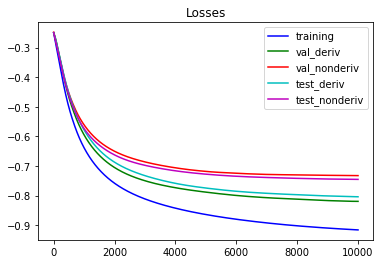

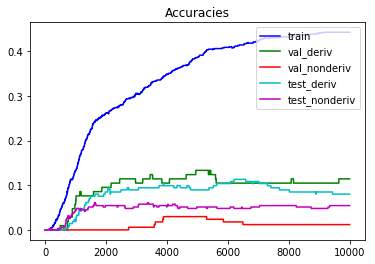

In [106]:
max_digit = 4
model = Linear(max_digit).cuda()
model = model.float()

optimizer = optim.Adam(model.parameters())

train, valid_deriv, test_deriv, valid_nonderiv, test_nonderiv = generate_dataset(puzzles[4], solutions, [.7, .8])
X, Y = generate_XY(train)
val_deriv_X, val_deriv_Y = generate_XY(valid_deriv)
val_nonderiv_X, val_nonderiv_Y = generate_XY(valid_nonderiv)
test_deriv_X, test_deriv_Y = generate_XY(test_deriv)
test_nonderiv_X, test_nonderiv_Y = generate_XY(test_nonderiv)

def closure():
    optimizer.zero_grad()
    prediction = model(X)
    total_cells = Y.shape[0]*Y.shape[1]
    flattened_prediction = prediction.reshape(total_cells, max_digit)
    flattened_Y = Y.reshape(total_cells)
    loss = nn.functional.nll_loss(flattened_prediction, flattened_Y)
    loss.backward()
    return loss

train_losses = []
val_deriv_losses = []
val_nonderiv_losses = []
test_nonderiv_losses = []
test_deriv_losses = []

train_accuracies = []
val_deriv_accuracies = []
val_nonderiv_accuracies = []
test_nonderiv_accuracies = []
test_deriv_accuracies = []

epochs = 10000

for epoch in tqdm_notebook(range(epochs), leave=True):
    optimizer.step(closure)
    train_loss, train_accuracy = get_performance(model, X, Y)
    val_deriv_loss, val_deriv_accuracy = get_performance(model, val_deriv_X, val_deriv_Y)
    val_nonderiv_loss, val_nonderiv_accuracy = get_performance(model, val_nonderiv_X, val_nonderiv_Y)
    test_deriv_loss, test_deriv_accuracy = get_performance(model, test_deriv_X, test_deriv_Y)
    test_nonderiv_loss, test_nonderiv_accuracy = get_performance(model, test_nonderiv_X, test_nonderiv_Y)
    
    train_losses.append(train_loss)
    val_deriv_losses.append(val_deriv_loss)
    val_nonderiv_losses.append(val_nonderiv_loss)
    test_nonderiv_losses.append(test_nonderiv_loss)
    test_deriv_losses.append(test_deriv_loss)
    
    train_accuracies.append(train_accuracy)
    val_deriv_accuracies.append(val_deriv_accuracy)
    val_nonderiv_accuracies.append(val_nonderiv_accuracy)
    test_deriv_accuracies.append(test_deriv_accuracy)
    test_nonderiv_accuracies.append(test_nonderiv_accuracy)
    
plt.plot(range(epochs), train_losses, '-b', label='training')
plt.plot(range(epochs), val_deriv_losses, '-g', label='val_deriv')
plt.plot(range(epochs), val_nonderiv_losses, '-r', label='val_nonderiv')
plt.plot(range(epochs), test_deriv_losses, '-c', label='test_deriv')
plt.plot(range(epochs), test_nonderiv_losses, '-m', label='test_nonderiv')
plt.title("Losses")
plt.legend(loc='upper right') 
plt.show()

plt.plot(range(epochs), train_accuracies, '-b', label='train')
plt.plot(range(epochs), val_deriv_accuracies, '-g', label='val_deriv')
plt.plot(range(epochs), val_nonderiv_accuracies, '-r', label='val_nonderiv')
plt.plot(range(epochs), test_deriv_accuracies, '-c', label='test_deriv')
plt.plot(range(epochs), test_nonderiv_accuracies, '-m', label='test_nonderiv')
plt.title("Accuracies")
plt.legend(loc='upper right')
plt.show()

In [15]:
max_digit = 4
model = FeedForward(max_digit, [128, 128])
model.double()

optimizer = optim.Adam(model.parameters())

train, valid_deriv, test_deriv, valid_nonderiv, test_nonderiv = generate_dataset(puzzles[4], solutions, [.7, .8])
X, Y = generate_XY(train)
val_deriv_X, val_deriv_Y = generate_XY(valid_deriv)
val_nonderiv_X, val_nonderiv_Y = generate_XY(valid_nonderiv)
test_deriv_X, test_deriv_Y = generate_XY(test_deriv)
test_nonderiv_X, test_nonderiv_Y = generate_XY(test_nonderiv)

def closure():
    optimizer.zero_grad()
    prediction = model(X)
    total_cells = Y.shape[0]*Y.shape[1]
    flattened_prediction = prediction.reshape(total_cells, max_digit)
    flattened_Y = Y.reshape(total_cells)
    loss = nn.functional.nll_loss(flattened_prediction, flattened_Y)
    loss.backward()
    return loss

train_losses = []
val_deriv_losses = []
val_nonderiv_losses = []
test_nonderiv_losses = []
test_deriv_losses = []

train_accuracies = []
val_deriv_accuracies = []
val_nonderiv_accuracies = []
test_nonderiv_accuracies = []
test_deriv_accuracies = []

epochs = 10000

for epoch in tqdm_notebook(range(epochs), leave=True):
    optimizer.step(closure)
    train_loss, train_accuracy = get_performance(model, X, Y)
    val_deriv_loss, val_deriv_accuracy = get_performance(model, val_deriv_X, val_deriv_Y)
    val_nonderiv_loss, val_nonderiv_accuracy = get_performance(model, val_nonderiv_X, val_nonderiv_Y)
    test_deriv_loss, test_deriv_accuracy = get_performance(model, test_deriv_X, test_deriv_Y)
    test_nonderiv_loss, test_nonderiv_accuracy = get_performance(model, test_nonderiv_X, test_nonderiv_Y)
    
    train_losses.append(train_loss)
    val_deriv_losses.append(val_deriv_loss)
    val_nonderiv_losses.append(val_nonderiv_loss)
    test_nonderiv_losses.append(test_nonderiv_loss)
    test_deriv_losses.append(test_deriv_loss)
    
    train_accuracies.append(train_accuracy)
    val_deriv_accuracies.append(val_deriv_accuracy)
    val_nonderiv_accuracies.append(val_nonderiv_accuracy)
    test_deriv_accuracies.append(test_deriv_accuracy)
    test_nonderiv_accuracies.append(test_nonderiv_accuracy)
    
plt.plot(range(epochs), train_losses, '-b', label='training')
plt.plot(range(epochs), val_deriv_losses, '-g', label='val_deriv')
plt.plot(range(epochs), val_nonderiv_losses, '-r', label='val_nonderiv')
plt.plot(range(epochs), test_deriv_losses, '-c', label='test_deriv')
plt.plot(range(epochs), test_nonderiv_losses, '-m', label='test_nonderiv')
plt.title("Losses")
plt.legend(loc='upper right') 
plt.show()

plt.plot(range(epochs), train_accuracies, '-b', label='train')
plt.plot(range(epochs), val_deriv_accuracies, '-g', label='val_deriv')
plt.plot(range(epochs), val_nonderiv_accuracies, '-r', label='val_nonderiv')
plt.plot(range(epochs), test_deriv_accuracies, '-c', label='test_deriv')
plt.plot(range(epochs), test_nonderiv_accuracies, '-m', label='test_nonderiv')
plt.title("Accuracies")
plt.legend(loc='upper right')
plt.show()

RuntimeError: Expected object of type torch.DoubleTensor but found type torch.cuda.FloatTensor for argument #4 'mat1'

/home/ajhnam/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':
/home/ajhnam/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


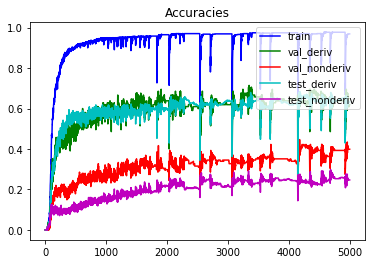

In [15]:
max_digit = 4
model = FeedForward(max_digit, [128, 128]).cuda()
model = model.float()

optimizer = optim.Adam(model.parameters())
train, valid_deriv, test_deriv, valid_nonderiv, test_nonderiv = generate_dataset(puzzles[4], solutions, [.7, .8])

train_X, train_Y = generate_XY(train)
val_deriv_X, val_deriv_Y = generate_XY(valid_deriv)
val_nonderiv_X, val_nonderiv_Y = generate_XY(valid_nonderiv)
test_deriv_X, test_deriv_Y = generate_XY(test_deriv)
test_nonderiv_X, test_nonderiv_Y = generate_XY(test_nonderiv)

train_losses = []
val_deriv_losses = []
val_nonderiv_losses = []
test_nonderiv_losses = []
test_deriv_losses = []

train_accuracies = []
val_deriv_accuracies = []
val_nonderiv_accuracies = []
test_nonderiv_accuracies = []
test_deriv_accuracies = []

def closure():
    optimizer.zero_grad()
    prediction = model(train_input)
    total_cells = target.shape[0]*target.shape[1]
    flattened_prediction = prediction.reshape(total_cells, max_digit)
    flattened_target = target.reshape(total_cells)
    loss = nn.functional.nll_loss(flattened_prediction, flattened_target)
    loss.backward(retain_graph=True)
    return loss

epochs = 5000
runs = 12

target = train_Y

losses = []
for epoch in tqdm_notebook(range(epochs), leave=True):
    train_input = train_X
    val_deriv_input = val_deriv_X
    val_nonderiv_input = val_nonderiv_X
    test_deriv_input = test_deriv_X
    test_nonderiv_input = test_nonderiv_X
    
    for i in range(runs):
        losses.append(float(optimizer.step(closure)))
        
        with torch.no_grad():
            train_output = model(train_input)
            val_deriv_output = model(val_deriv_input)
            val_nonderiv_output = model(val_nonderiv_input)
            test_deriv_output = model(test_deriv_input)
            test_nonderiv_output = model(test_nonderiv_input)

            train_input = flatten_prediction(train_output)
            val_deriv_input = flatten_prediction(val_deriv_output)
            val_nonderiv_input = flatten_prediction(val_nonderiv_output)
            test_deriv_input = flatten_prediction(test_deriv_output)
            test_nonderiv_input = flatten_prediction(test_nonderiv_output)

    train_accuracy = get_model_accuracy(train_output, train_Y)
    val_deriv_accuracy = get_model_accuracy(val_deriv_output, val_deriv_Y)
    val_nonderiv_accuracy = get_model_accuracy(val_nonderiv_output, val_nonderiv_Y)
    test_deriv_accuracy = get_model_accuracy(test_deriv_output, test_deriv_Y)
    test_nonderiv_accuracy = get_model_accuracy(test_nonderiv_output, test_nonderiv_Y)
        
    train_accuracies.append(train_accuracy)
    val_deriv_accuracies.append(val_deriv_accuracy)
    val_nonderiv_accuracies.append(val_nonderiv_accuracy)
    test_deriv_accuracies.append(test_deriv_accuracy)
    test_nonderiv_accuracies.append(test_nonderiv_accuracy)

plt.plot(range(epochs), train_accuracies, '-b', label='train')
plt.plot(range(epochs), val_deriv_accuracies, '-g', label='val_deriv')
plt.plot(range(epochs), val_nonderiv_accuracies, '-r', label='val_nonderiv')
plt.plot(range(epochs), test_deriv_accuracies, '-c', label='test_deriv')
plt.plot(range(epochs), test_nonderiv_accuracies, '-m', label='test_nonderiv')
plt.title("Accuracies")
plt.legend(loc='upper right')
plt.show()

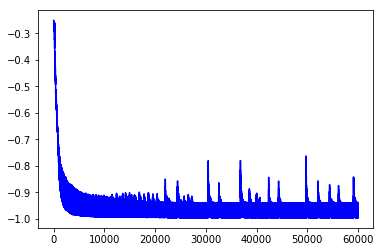

In [16]:
plt.plot(range(len(losses)), losses, '-b', label='losses')

In [ ]:
max_digit = 4
model = FeedForward(max_digit, [128, 128]).cuda()
model = model.float()

optimizer = optim.Adam(model.parameters())
train, valid_deriv, test_deriv, valid_nonderiv, test_nonderiv = generate_dataset(puzzles[4], solutions, [.7, .8])

train_X, train_Y = generate_XY(train)
val_deriv_X, val_deriv_Y = generate_XY(valid_deriv)
val_nonderiv_X, val_nonderiv_Y = generate_XY(valid_nonderiv)
test_deriv_X, test_deriv_Y = generate_XY(test_deriv)
test_nonderiv_X, test_nonderiv_Y = generate_XY(test_nonderiv)

train_losses = []
val_deriv_losses = []
val_nonderiv_losses = []
test_nonderiv_losses = []
test_deriv_losses = []

train_accuracies = []
val_deriv_accuracies = []
val_nonderiv_accuracies = []
test_nonderiv_accuracies = []
test_deriv_accuracies = []

def closure():
    optimizer.zero_grad()
    prediction = model(train_input)
    total_cells = target.shape[0]*target.shape[1]
    flattened_prediction = prediction.reshape(total_cells, max_digit)
    flattened_target = target.reshape(total_cells)
    loss = nn.functional.nll_loss(flattened_prediction, flattened_target)
    loss.backward(retain_graph=True)
    return loss

epochs = 5000
runs = 12

target = train_Y

losses = []
for epoch in tqdm_notebook(range(epochs), leave=True):
    train_input = train_X
    val_deriv_input = val_deriv_X
    val_nonderiv_input = val_nonderiv_X
    test_deriv_input = test_deriv_X
    test_nonderiv_input = test_nonderiv_X
    
    for i in range(runs):
        losses.append(float(optimizer.step(closure)))
        
        with torch.no_grad():
            train_output = model(train_input)
            val_deriv_output = model(val_deriv_input)
            val_nonderiv_output = model(val_nonderiv_input)
            test_deriv_output = model(test_deriv_input)
            test_nonderiv_output = model(test_nonderiv_input)

            train_input = flatten_prediction(train_output)
            val_deriv_input = flatten_prediction(val_deriv_output)
            val_nonderiv_input = flatten_prediction(val_nonderiv_output)
            test_deriv_input = flatten_prediction(test_deriv_output)
            test_nonderiv_input = flatten_prediction(test_nonderiv_output)

    train_accuracy = get_model_accuracy(train_output, train_Y)
    val_deriv_accuracy = get_model_accuracy(val_deriv_output, val_deriv_Y)
    val_nonderiv_accuracy = get_model_accuracy(val_nonderiv_output, val_nonderiv_Y)
    test_deriv_accuracy = get_model_accuracy(test_deriv_output, test_deriv_Y)
    test_nonderiv_accuracy = get_model_accuracy(test_nonderiv_output, test_nonderiv_Y)
        
    train_accuracies.append(train_accuracy)
    val_deriv_accuracies.append(val_deriv_accuracy)
    val_nonderiv_accuracies.append(val_nonderiv_accuracy)
    test_deriv_accuracies.append(test_deriv_accuracy)
    test_nonderiv_accuracies.append(test_nonderiv_accuracy)

plt.plot(range(epochs), train_accuracies, '-b', label='train')
plt.plot(range(epochs), val_deriv_accuracies, '-g', label='val_deriv')
plt.plot(range(epochs), val_nonderiv_accuracies, '-r', label='val_nonderiv')
plt.plot(range(epochs), test_deriv_accuracies, '-c', label='test_deriv')
plt.plot(range(epochs), test_nonderiv_accuracies, '-m', label='test_nonderiv')
plt.title("Accuracies")
plt.legend(loc='upper right')
plt.show()

In [ ]:
get_predicted_boards(train_output)[0]

In [ ]:
train_Y[0]